<a href="https://colab.research.google.com/github/Gracey701/Project-2/blob/main/Stroke_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - Stroke

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config, metrics
set_config(display='diagram')
np.random.seed(42)

## About the data
- Link: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
- About: Dataset used to predict if a pateitn is likely to get a stroke or not depending on the following features below such as gender, age, etc.
- Target: stroke (1:had stroke, 0: no stroke)
- Row represents: patient
- Type: Classification
- Features: 11 features not including target
- Rows: 5110
- Challenges: choosing what kind of imputation to use

In [188]:
stroke = pd.read_csv('/content/archive (2).zip')
#copies of dataframe
eda_stroke = stroke.copy()
ml_stroke = stroke.copy()
stroke.info()
stroke.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Exploring and Cleaning Data

- Don't need id column as it's unique to each row

In [189]:
# delete unnecessary column(s)
eda_stroke = stroke.drop(columns=['id'])
eda_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [190]:
#no duplicates
eda_stroke.duplicated().sum()

0

In [191]:
eda_stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

bmi columns has 201 missing values
- won't drop as it's above 2% of data
- can fill in missing values with average of all bmi values for exploratory purposes as it is a float feature
- use simple imputation in a pipeline using average value for preprocessing on training data

In [192]:
avg_bmi = eda_stroke['bmi'].mean()
eda_stroke['bmi'].fillna(avg_bmi, inplace=True)
eda_stroke.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Check for inconsistencies in categorical features

In [193]:
eda_stroke['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [194]:
eda_stroke['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [195]:
eda_stroke['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

In [196]:
eda_stroke['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [197]:
eda_stroke['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [198]:
eda_stroke['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [199]:
eda_stroke['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

## Visuals

### Univariate Exploratory

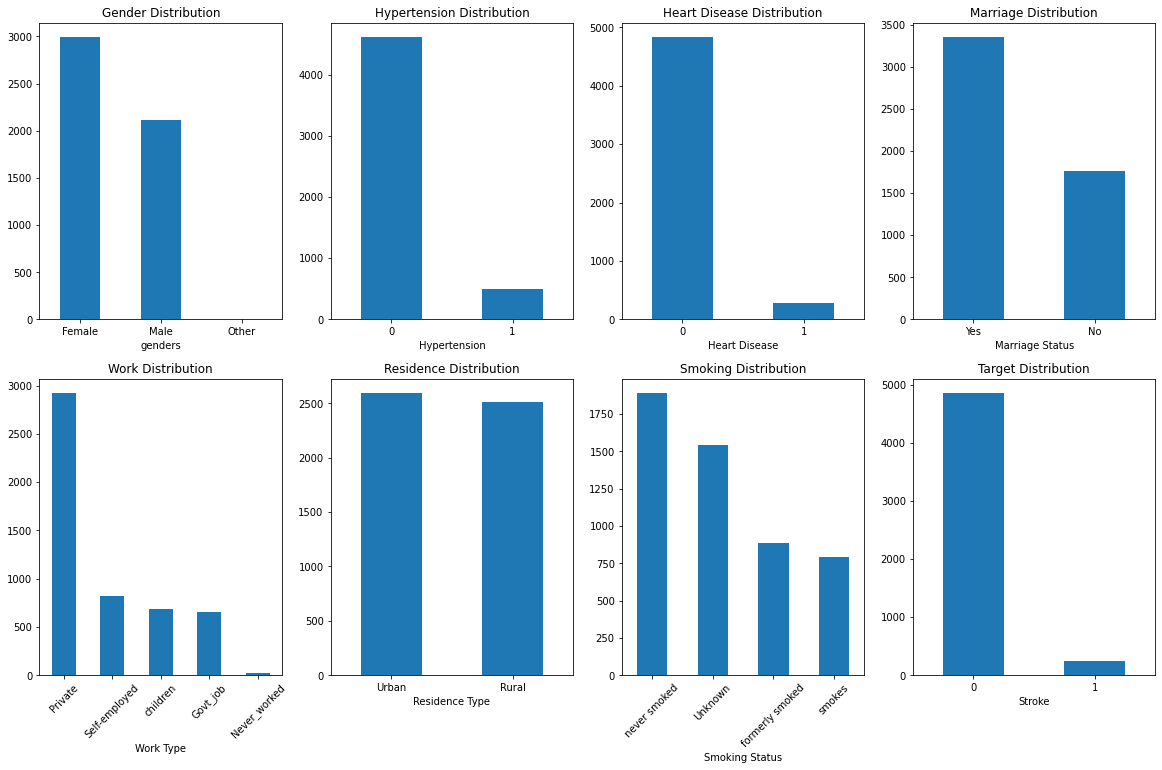

In [200]:
plt.figure(figsize=(20,12))
#make subplots 
plt.subplot(2,4,1)
eda_stroke['gender'].value_counts().plot(kind = 'bar')
plt.xlabel('genders')
plt.xticks(rotation=0)
plt.title('Gender Distribution')

plt.subplot(2,4,2)
eda_stroke['hypertension'].value_counts().plot(kind='bar')
plt.xlabel('Hypertension')
plt.xticks(rotation=0)
plt.title('Hypertension Distribution')

plt.subplot(2,4,3)
eda_stroke['heart_disease'].value_counts().plot(kind = 'bar')
plt.xlabel('Heart Disease')
plt.xticks(rotation=0)
plt.title('Heart Disease Distribution')

plt.subplot(2,4,4)
eda_stroke['ever_married'].value_counts().plot(kind = 'bar')
plt.xlabel('Marriage Status')
plt.xticks(rotation=0)
plt.title('Marriage Distribution')

plt.subplot(2,4,5)
eda_stroke['work_type'].value_counts().plot(kind = 'bar')
plt.xlabel('Work Type')
plt.xticks(rotation=45)
plt.title('Work Distribution')

plt.subplot(2,4,6)
eda_stroke['Residence_type'].value_counts().plot(kind = 'bar')
plt.xlabel('Residence Type')
plt.xticks(rotation=0)
plt.title('Residence Distribution')

plt.subplot(2,4,7)
eda_stroke['smoking_status'].value_counts().plot(kind = 'bar')
plt.xlabel('Smoking Status')
plt.xticks(rotation=45)
plt.title('Smoking Distribution')

plt.subplot(2,4,8)
eda_stroke['stroke'].value_counts().plot(kind = 'bar')
plt.xlabel('Stroke')
plt.xticks(rotation=0)
plt.title('Target Distribution');

Text(0.5, 1.0, 'Bmi Distribution')

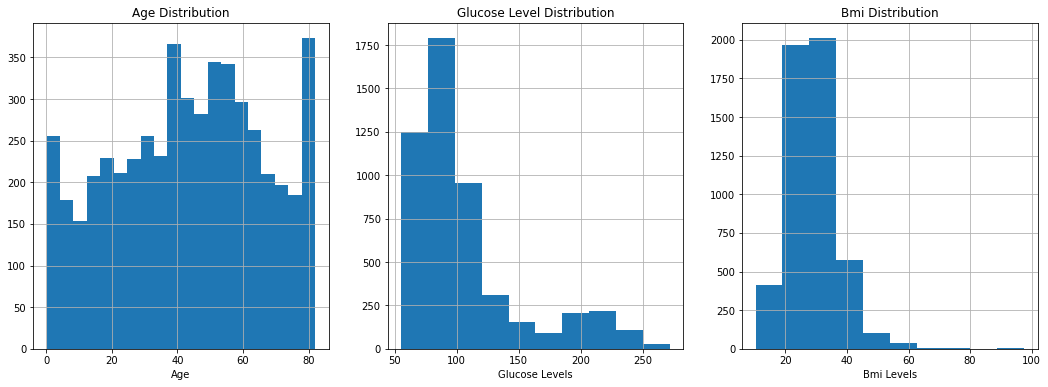

In [201]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
eda_stroke['age'].hist(bins='auto')
plt.xlabel('Age')
plt.title('Age Distribution')

plt.subplot(1,3,2)
eda_stroke['avg_glucose_level'].hist()
plt.xlabel('Glucose Levels')
plt.title('Glucose Level Distribution')

plt.subplot(1,3,3)
eda_stroke['bmi'].hist()
plt.xlabel('Bmi Levels')
plt.title('Bmi Distribution')

### Outliers

In [202]:
eda_stroke.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


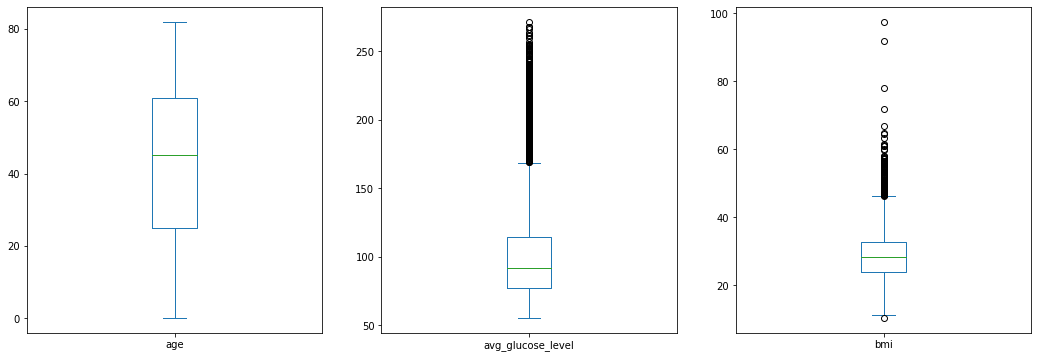

In [203]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
eda_stroke['age'].plot(kind='box')

plt.subplot(1,3,2)
eda_stroke['avg_glucose_level'].plot(kind='box')

plt.subplot(1,3,3)
eda_stroke['bmi'].plot(kind='box');

avg_glucose_level and bmi columns have many outliers surpassing the maximum value

### Finding trends via heatmap

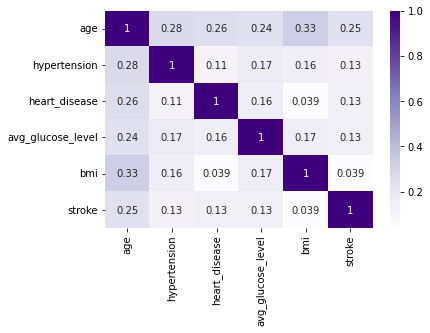

There are no strong correlations between the target and other features. This goes for between features as well. 
The strongest correlation is a rate of 0.0.33 between age and bmi. 
The highest correlation between the target and another feature would be with age, being 0.25.


In [204]:
import seaborn as sns
corr = eda_stroke.corr()
sns.heatmap(corr, cmap = 'Purples', annot = True);
plt.show()
print('There are no strong correlations between the target and other features. This goes for between features as well. \nThe strongest correlation is a rate of 0.0.33 between age and bmi. \nThe highest correlation between the target and another feature would be with age, being 0.25.')

### Multivariate Exploratory

replacing all the 1 and 0 with pos and neg for easier understanding of graphs

In [205]:
eda_stroke['hypertension'] = eda_stroke['hypertension'].replace({1: 'pos', 0: 'neg'})
eda_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,neg,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,neg,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,neg,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,neg,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,pos,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [206]:
eda_stroke['heart_disease'] = eda_stroke['heart_disease'].replace({1: 'pos', 0: 'neg'})
eda_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,neg,pos,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,neg,neg,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,neg,pos,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,neg,neg,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,pos,neg,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [207]:
eda_stroke['stroke'] = eda_stroke['stroke'].replace({1: 'pos', 0: 'neg'})
eda_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,neg,pos,Yes,Private,Urban,228.69,36.600000,formerly smoked,pos
1,Female,61.0,neg,neg,Yes,Self-employed,Rural,202.21,28.893237,never smoked,pos
2,Male,80.0,neg,pos,Yes,Private,Rural,105.92,32.500000,never smoked,pos
3,Female,49.0,neg,neg,Yes,Private,Urban,171.23,34.400000,smokes,pos
4,Female,79.0,pos,neg,Yes,Self-employed,Rural,174.12,24.000000,never smoked,pos


#### Stroke vs Age

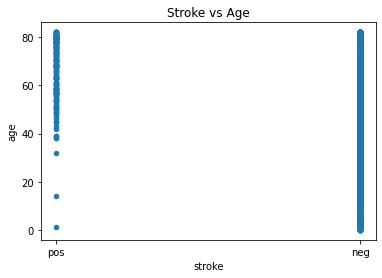

The data has a variety of non-stroke patients of all ages, whereas those who have had strokes are mostly in the ranges of around 40-80.


In [208]:
eda_stroke.plot.scatter(x = 'stroke', y = 'age')
plt.title('Stroke vs Age');
plt.show()
print('The data has a variety of non-stroke patients of all ages, whereas those who have had strokes are mostly in the ranges of around 40-80.')

In [209]:
avg_age = eda_stroke.groupby('stroke')['age'].mean()
avg_age

stroke
neg    41.971545
pos    67.728193
Name: age, dtype: float64

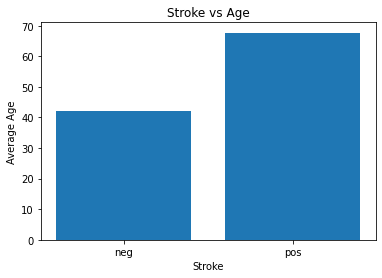

Those that have had strokes tend to be much older on average than those who have not. 
This reflects the positive correlation displayed by the heatmap.


In [210]:
plt.bar(avg_age.index, avg_age.values)
plt.ylabel('Average Age')
plt.xlabel('Stroke')
plt.title('Stroke vs Age');
plt.show()
print('Those that have had strokes tend to be much older on average than those who have not. \nThis reflects the positive correlation displayed by the heatmap.')

#### Stroke vs Glucose Lvl

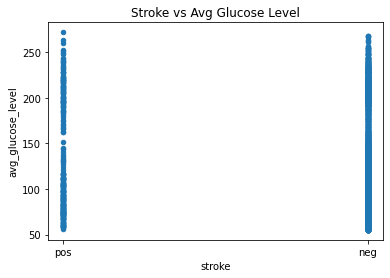

There does not seem to be a clear trend between having a stroke and average glucose level based off the scatter plot.


In [211]:
eda_stroke.plot.scatter(x = 'stroke', y = 'avg_glucose_level')
plt.title('Stroke vs Avg Glucose Level');
plt.show()
print('There does not seem to be a clear trend between having a stroke and average glucose level based off the scatter plot.')

In [212]:
avg_glu = eda_stroke.groupby('stroke')['avg_glucose_level'].mean()
avg_glu

stroke
neg    104.795513
pos    132.544739
Name: avg_glucose_level, dtype: float64

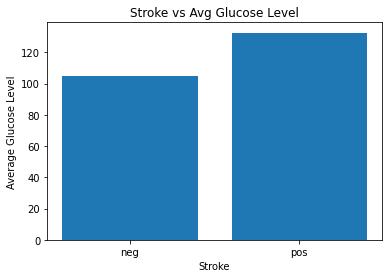

Those with higher average glucose levels seem to have a higher chance of having a stroke.


In [213]:
plt.bar(avg_glu.index, avg_glu.values)
plt.ylabel('Average Glucose Level')
plt.xlabel('Stroke')
plt.title('Stroke vs Avg Glucose Level');
plt.show()
print('Those with higher average glucose levels seem to have a higher chance of having a stroke.')

#### Stroke vs BMI

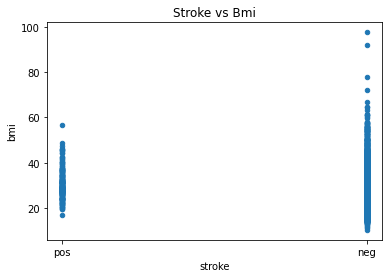

Most patients represented in the data seem to have bmi levels between 20 and 50, regardless of having strokes or not. 
However the group of no strokes have some stretching out to 100 bmi.


In [214]:
eda_stroke.plot.scatter(x = 'stroke', y = 'bmi')
plt.title('Stroke vs Bmi');
plt.show()
print('Most patients represented in the data seem to have bmi levels between 20 and 50, regardless of having strokes or not. \nHowever the group of no strokes have some stretching out to 100 bmi.')

In [215]:
avg_bmi = eda_stroke.groupby('stroke')['bmi'].mean()
avg_bmi

stroke
neg    28.825388
pos    30.217789
Name: bmi, dtype: float64

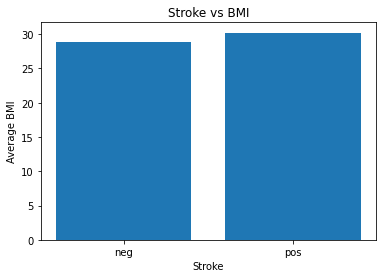

BMI had the weakest correlation with the target variable which is further supported in this bar graph. Both groups have a similar bmi average.


In [216]:
plt.bar(avg_bmi.index, avg_bmi.values)
plt.ylabel('Average BMI')
plt.xlabel('Stroke')
plt.title('Stroke vs BMI');
plt.show()
print('BMI had the weakest correlation with the target variable which is further supported in this bar graph. Both groups have a similar bmi average.')

#### Grouped by Smoke Status

In [217]:
smoke_group = eda_stroke.groupby(['smoking_status','stroke']).mean().reset_index()
smoke_group

,smoking_status,stroke,age,avg_glucose_level,bmi
0,Unknown,neg,29.112011,98.810127,25.687648
1,Unknown,pos,65.836596,124.808936,29.176133
2,formerly smoked,neg,53.753374,111.175092,30.648912
3,formerly smoked,pos,68.628571,132.806857,30.620173
4,never smoked,neg,45.567703,106.292042,29.940716
5,never smoked,pos,70.311111,132.907222,30.336216
6,smokes,neg,46.212851,106.219906,30.433425
7,smokes,pos,62.809524,139.987857,30.459041


In [218]:
smoke_group_glu = smoke_group.sort_values(by = 'avg_glucose_level')
smoke_group_glu

,smoking_status,stroke,age,avg_glucose_level,bmi
0,Unknown,neg,29.112011,98.810127,25.687648
6,smokes,neg,46.212851,106.219906,30.433425
4,never smoked,neg,45.567703,106.292042,29.940716
2,formerly smoked,neg,53.753374,111.175092,30.648912
1,Unknown,pos,65.836596,124.808936,29.176133
3,formerly smoked,pos,68.628571,132.806857,30.620173
5,never smoked,pos,70.311111,132.907222,30.336216
7,smokes,pos,62.809524,139.987857,30.459041


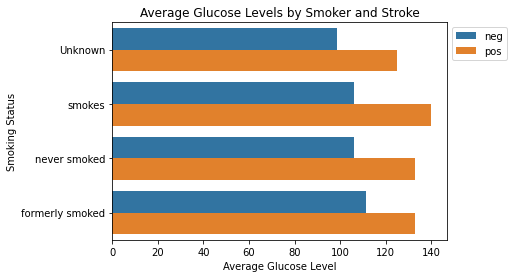

Those that have had strokes have the highest average glucose level within their smoking status group. 
Those that have smoked have the highest average glucose level within the ones that had stokes. 
Overall those that have smokes generally have higher glucose levels and those that have even higher levels have had strokes.


In [219]:
sns.barplot(data = smoke_group_glu, x = 'avg_glucose_level', y = 'smoking_status', hue = 'stroke')
plt.title('Average Glucose Levels by Smoker and Stroke')
plt.xlabel('Average Glucose Level')
plt.ylabel('Smoking Status')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('Those that have had strokes have the highest average glucose level within their smoking status group. \nThose that have smoked have the highest average glucose level within the ones that had stokes. \nOverall those that have smokes generally have higher glucose levels and those that have even higher levels have had strokes.')

In [220]:
smoke_group_age = smoke_group.sort_values(by = 'age')
smoke_group_age

,smoking_status,stroke,age,avg_glucose_level,bmi
0,Unknown,neg,29.112011,98.810127,25.687648
4,never smoked,neg,45.567703,106.292042,29.940716
6,smokes,neg,46.212851,106.219906,30.433425
2,formerly smoked,neg,53.753374,111.175092,30.648912
7,smokes,pos,62.809524,139.987857,30.459041
1,Unknown,pos,65.836596,124.808936,29.176133
3,formerly smoked,pos,68.628571,132.806857,30.620173
5,never smoked,pos,70.311111,132.907222,30.336216


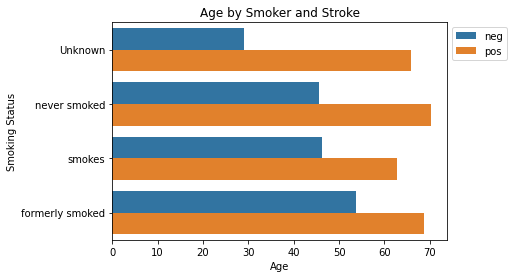

Within all groups, most of the older ones have had strokes whereas the younger ones have not. 
The ones that currently smoke have strokes at a younger age on average than those who have never smoked.


In [221]:
sns.barplot(data = smoke_group_age, x = 'age', y = 'smoking_status', hue = 'stroke')
plt.title('Age by Smoker and Stroke')
plt.xlabel('Age')
plt.ylabel('Smoking Status')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('Within all groups, most of the older ones have had strokes whereas the younger ones have not. \nThe ones that currently smoke have strokes at a younger age on average than those who have never smoked.')

#### Grouped by Residence Type

In [222]:
res_group = eda_stroke.groupby(['Residence_type','stroke']).mean().reset_index()
res_group

,Residence_type,stroke,age,avg_glucose_level,bmi
0,Rural,neg,41.729017,105.245746,28.845063
1,Rural,pos,67.570175,130.153947,29.928117
2,Urban,neg,42.208062,104.356440,28.806200
3,Urban,pos,67.861630,134.563630,30.462401


In [223]:
res_group_glu = res_group.sort_values(by = 'avg_glucose_level')
res_group_glu

,Residence_type,stroke,age,avg_glucose_level,bmi
2,Urban,neg,42.208062,104.356440,28.806200
0,Rural,neg,41.729017,105.245746,28.845063
1,Rural,pos,67.570175,130.153947,29.928117
3,Urban,pos,67.861630,134.563630,30.462401


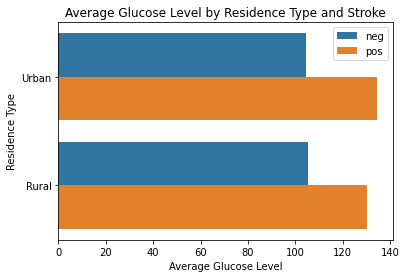

Those that live in rural and urban residences seem to have similar glucose levels on average for those that have not had strokes. 
Those that live in the urban area and HAVE HAD strokes have slightly higher glucose levels by about 30.


In [224]:
sns.barplot(data = res_group_glu, x = 'avg_glucose_level', y = 'Residence_type', hue = 'stroke')
plt.title('Average Glucose Level by Residence Type and Stroke')
plt.xlabel('Average Glucose Level')
plt.ylabel('Residence Type')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('Those that live in rural and urban residences seem to have similar glucose levels on average for those that have not had strokes. \nThose that live in the urban area and HAVE HAD strokes have slightly higher glucose levels by about 30.')

In [225]:
res_group_age = res_group.sort_values(by = 'age')
res_group_age

,Residence_type,stroke,age,avg_glucose_level,bmi
0,Rural,neg,41.729017,105.245746,28.845063
2,Urban,neg,42.208062,104.356440,28.806200
1,Rural,pos,67.570175,130.153947,29.928117
3,Urban,pos,67.861630,134.563630,30.462401


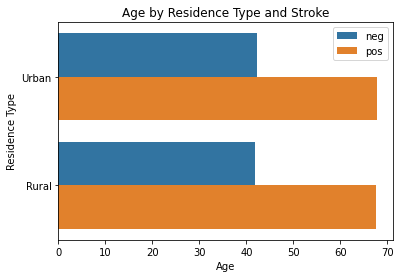

On average, those that are older have had strokes from both residence types compared to the younger generation. 
There is no clear correlation between residence type and age with having strokes.


In [226]:
sns.barplot(data = res_group_glu, x = 'age', y = 'Residence_type', hue = 'stroke')
plt.title('Age by Residence Type and Stroke')
plt.xlabel('Age')
plt.ylabel('Residence Type')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('On average, those that are older have had strokes from both residence types compared to the younger generation. \nThere is no clear correlation between residence type and age with having strokes.')

#### Grouped by Heart Disease

In [227]:
heart_group = eda_stroke.groupby(['heart_disease','stroke']).mean().reset_index()
heart_group

,heart_disease,stroke,age,avg_glucose_level,bmi
0,neg,neg,40.712150,103.490164,28.763404
1,neg,pos,66.778812,125.179257,30.158301
2,pos,neg,67.445415,131.198908,30.079145
3,pos,pos,71.808511,164.200638,30.473461


In [228]:
heart_group_glu = heart_group.sort_values(by = 'avg_glucose_level')
heart_group_glu 

,heart_disease,stroke,age,avg_glucose_level,bmi
0,neg,neg,40.712150,103.490164,28.763404
1,neg,pos,66.778812,125.179257,30.158301
2,pos,neg,67.445415,131.198908,30.079145
3,pos,pos,71.808511,164.200638,30.473461


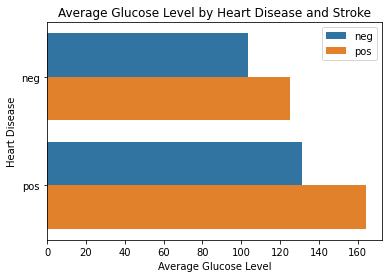

Those who have had heart disease all have higher glucose levels then their respective counterparts who have not. 
Furthermore, those who have had heart disease along with a significant high glucose level seem to get strokes.


In [229]:
sns.barplot(data = heart_group_glu, x = 'avg_glucose_level', y = 'heart_disease', hue = 'stroke')
plt.title('Average Glucose Level by Heart Disease and Stroke')
plt.xlabel('Average Glucose Level')
plt.ylabel('Heart Disease')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('Those who have had heart disease all have higher glucose levels then their respective counterparts who have not. \nFurthermore, those who have had heart disease along with a significant high glucose level seem to get strokes.')

In [230]:
heart_group_age = heart_group.sort_values(by = 'age')
heart_group_age

,heart_disease,stroke,age,avg_glucose_level,bmi
0,neg,neg,40.712150,103.490164,28.763404
1,neg,pos,66.778812,125.179257,30.158301
2,pos,neg,67.445415,131.198908,30.079145
3,pos,pos,71.808511,164.200638,30.473461


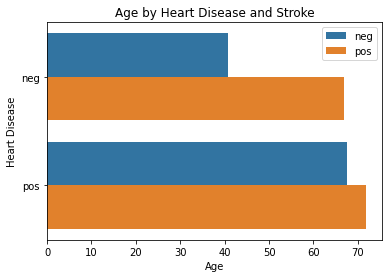

The older patients seem to be more likely to have heart diease as well as having strokes. 
Those that are younger generally have not had heart disease nor stroke. 


In [231]:
sns.barplot(data = heart_group_age, x = 'age', y = 'heart_disease', hue = 'stroke')
plt.title('Age by Heart Disease and Stroke')
plt.xlabel('Age')
plt.ylabel('Heart Disease')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('The older patients seem to be more likely to have heart diease as well as having strokes. \nThose that are younger generally have not had heart disease nor stroke. ')

##### Heart Disease Filter

In [232]:
heart_filter = eda_stroke['heart_disease'] == 'pos'
heartdisease = eda_stroke.loc[heart_filter, :]
no_heart = eda_stroke.loc[~heart_filter, :]
heartdisease.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,neg,pos,Yes,Private,Urban,228.69,36.600000,formerly smoked,pos
2,Male,80.0,neg,pos,Yes,Private,Rural,105.92,32.500000,never smoked,pos
6,Male,74.0,pos,pos,Yes,Private,Rural,70.09,27.400000,never smoked,pos
11,Female,61.0,neg,pos,Yes,Govt_job,Rural,120.46,36.800000,smokes,pos
13,Male,78.0,neg,pos,Yes,Private,Urban,219.84,28.893237,Unknown,pos


In [233]:
heartdisease['stroke'].value_counts()

neg    229
pos     47
Name: stroke, dtype: int64

In [234]:
no_heart['stroke'].value_counts()

neg    4632
pos     202
Name: stroke, dtype: int64

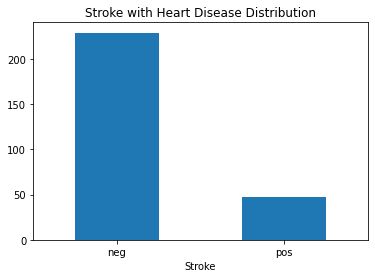

Among those that have heart disease, most of them have not had a stroke. The rate is about 47/229 which is about 21%. 
This means there was a 21% chance of having a stroke if you have heart disease.


In [235]:
heartdisease['stroke'].value_counts().plot(kind='bar')
plt.xlabel('Stroke')
plt.xticks(rotation=0)
plt.title('Stroke with Heart Disease Distribution');
plt.show()
print('Among those that have heart disease, most of them have not had a stroke. The rate is about 47/229 which is about 21%. \nThis means there was a 21% chance of having a stroke if you have heart disease.')

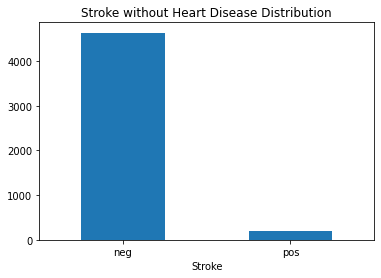

Among those that do not have heart disease, most do not have strokes, even moreso than those who have not had heart disease. The rate is 202/4632 which is 4%. 
This is significantly lower than the heart disease graph above.


In [236]:
no_heart['stroke'].value_counts().plot(kind='bar')
plt.xlabel('Stroke')
plt.xticks(rotation=0)
plt.title('Stroke without Heart Disease Distribution');
plt.show()
print('Among those that do not have heart disease, most do not have strokes, even moreso than those who have not had heart disease. The rate is 202/4632 which is 4%. \nThis is significantly lower than the heart disease graph above.')

#### Grouped by Hypertension

In [237]:
hyper_group = eda_stroke.groupby(['hypertension','stroke']).mean().reset_index()
hyper_group

,hypertension,stroke,age,avg_glucose_level,bmi
0,neg,neg,40.112820,102.488738,28.423885
1,neg,pos,66.832350,129.278087,30.041366
2,pos,neg,61.027778,128.445301,32.941719
3,pos,pos,70.212121,141.602273,30.706961


In [238]:
hyper_group_glu = hyper_group.sort_values(by = 'avg_glucose_level')
hyper_group_glu

,hypertension,stroke,age,avg_glucose_level,bmi
0,neg,neg,40.112820,102.488738,28.423885
2,pos,neg,61.027778,128.445301,32.941719
1,neg,pos,66.832350,129.278087,30.041366
3,pos,pos,70.212121,141.602273,30.706961


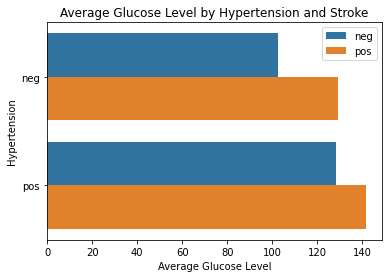

Those with hypertension also have higher glucose levels on average compared to their negative hypertension counterparts. 
Those that have hypertension as well as high glucose levels also get a stroke, while those that do not have hypertension along with a lower glucose level have not had a stroke.


In [239]:
sns.barplot(data = hyper_group_glu, x = 'avg_glucose_level', y = 'hypertension', hue = 'stroke')
plt.title('Average Glucose Level by Hypertension and Stroke')
plt.xlabel('Average Glucose Level')
plt.ylabel('Hypertension')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('Those with hypertension also have higher glucose levels on average compared to their negative hypertension counterparts. \nThose that have hypertension as well as high glucose levels also get a stroke, while those that do not have hypertension along with a lower glucose level have not had a stroke.')

In [240]:
hyper_group_age = hyper_group.sort_values(by = 'age')
hyper_group_age

,hypertension,stroke,age,avg_glucose_level,bmi
0,neg,neg,40.112820,102.488738,28.423885
2,pos,neg,61.027778,128.445301,32.941719
1,neg,pos,66.832350,129.278087,30.041366
3,pos,pos,70.212121,141.602273,30.706961


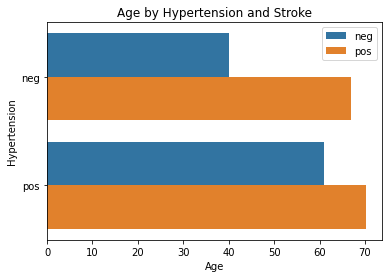

No significant difference between the two groups of negative and positive hypertension who have had strokes. 
The younger people seem to be more healthy as they have no hypertension and have not had a stroke. 
The older people tend to either have had a stroke or have hypertension.


In [241]:
sns.barplot(data = hyper_group_glu, x = 'age', y = 'hypertension', hue = 'stroke')
plt.title('Age by Hypertension and Stroke')
plt.xlabel('Age')
plt.ylabel('Hypertension')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('No significant difference between the two groups of negative and positive hypertension who have had strokes. \nThe younger people seem to be more healthy as they have no hypertension and have not had a stroke. \nThe older people tend to either have had a stroke or have hypertension.')

#### Graph for highest correlation

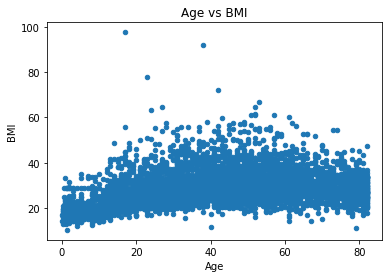

As shown in the heatmap, there does seem to be a positive correlation with some outliers. The older patients generally have higher BMI. 
However, the correlation is not too strong or noticeable.


In [242]:
#age and bmi with correlation of 0.33
eda_stroke.plot.scatter(x = 'age', y = 'bmi')
plt.title('Age vs BMI')
plt.xlabel('Age')
plt.ylabel('BMI');
plt.show()
print('As shown in the heatmap, there does seem to be a positive correlation with some outliers. The older patients generally have higher BMI. \nHowever, the correlation is not too strong or noticeable.')

### Two Visualizations Chosen for Stakeholder

Heart Disease Filters to get Stroke Count (Following two are not multivariate, but was an interesting trend found)
- From those who have heart disease, they have around a 21% chance of getting a stroke, whereas those who do not have heart disease only have a 4% chance of having a stroke.
- Value Counts
  - Heart Disease: 47/229 (pos/neg)
  - No Heart Disease: 202/4632 (pos/neg)
- Those with heart disease are at more risk of having a stroke
- If the stakeholder is an insurance company they should keep in mind holders that have heart disease as they would cost more in the future

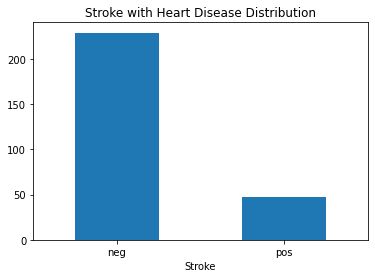

In [243]:
heartdisease['stroke'].value_counts().plot(kind='bar')
plt.xlabel('Stroke')
plt.xticks(rotation=0)
plt.title('Stroke with Heart Disease Distribution');

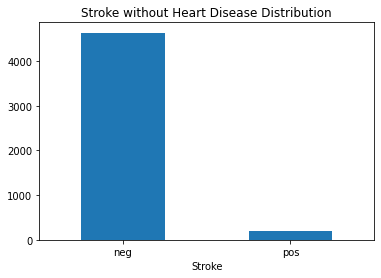

In [244]:
no_heart['stroke'].value_counts().plot(kind='bar')
plt.xlabel('Stroke')
plt.xticks(rotation=0)
plt.title('Stroke without Heart Disease Distribution');
plt.show()

Average Glucose by Heart Disease and Stroke graph
- This graph shows those with heart disease also tend to have higher glucose levels on average than those who do not have the disease
- Within the positive heart disease group, ones that have had a stroke have much higher glucose levels than all the others
- Within the negative heart disease group, those who have had a stroke also have a much higher glucose level than those who have not had a stroke
- Could be a correlation between having heart disease and high glucose and the possibility of having a stroke
- If stakeholder is an insurance company they should be more cautious of holders with a heart disease and high glucose levels as they are more at risk of getting a stroke, being more costly

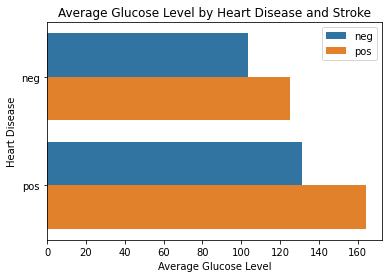

Those who have had heart disease all have higher glucose levels then their respective counterparts who have not. 
Furthermore, those who have had heart disease along with a significant high glucose level seem to get strokes.


In [290]:
sns.barplot(data = heart_group_glu, x = 'avg_glucose_level', y = 'heart_disease', hue = 'stroke')
plt.title('Average Glucose Level by Heart Disease and Stroke')
plt.xlabel('Average Glucose Level')
plt.ylabel('Heart Disease')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('test')
plt.show()
print('Those who have had heart disease all have higher glucose levels then their respective counterparts who have not. \nFurthermore, those who have had heart disease along with a significant high glucose level seem to get strokes.')

Age by Hypertension and Stroke
- Graphs shows the group with hypertension also seems to be older than their non-hypertension counterparts
  - Those with hypertension who have not had strokes are older than those without hypertension who have also not had strokes
  - Those with hypertension who HAVE had strokes are older than those without hypertension who have also had strokes
- If stakeholder is an insurance company they should be cautious of holders who have hypertension and are older as they would be more costly with higher risk of having a stroke

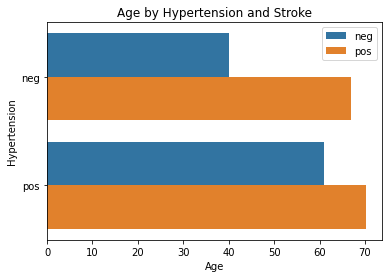

No significant difference between the two groups of negative and positive hypertension who have had strokes. 
The younger people seem to be more healthy as they have no hypertension and have not had a stroke. 
The older people tend to either have had a stroke or have hypertension.


In [246]:
sns.barplot(data = hyper_group_glu, x = 'age', y = 'hypertension', hue = 'stroke')
plt.title('Age by Hypertension and Stroke')
plt.xlabel('Age')
plt.ylabel('Hypertension')
plt.legend(bbox_to_anchor=(1,1));
plt.show()
print('No significant difference between the two groups of negative and positive hypertension who have had strokes. \nThe younger people seem to be more healthy as they have no hypertension and have not had a stroke. \nThe older people tend to either have had a stroke or have hypertension.')

## Preprocessing

In [247]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [248]:
# delete unnecessary column(s)
ml_stroke = stroke.drop(columns=['id'])
ml_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


features:
- categorical: gender, hypertension, heart disease, ever_married, work_type, Residence_type, smoking_status, stroke
  - one hot encoding
- numerical: age, avg_glucose_level, and bmi
  -scaler

In [249]:
#identify missing values
ml_stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Will fill in missing values with the mean value as its a numeric feature.

In [250]:
# Validation Split
X = ml_stroke.drop('stroke', axis=1) 
y = ml_stroke['stroke'] 
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4505,Female,60.0,1,0,Yes,Private,Urban,234.50,43.7,never smoked
3576,Male,41.0,0,0,Yes,Private,Rural,83.97,28.5,formerly smoked
3032,Male,52.0,0,0,Yes,Private,Urban,87.51,30.5,formerly smoked
1867,Female,55.0,0,0,Yes,Private,Rural,63.47,27.8,Unknown
494,Female,55.0,0,0,Yes,Private,Rural,111.19,39.7,formerly smoked


### Imputation and transformers into pipelines

In [251]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
mean_imputer = SimpleImputer(strategy='mean')
num_pipeline = make_pipeline(mean_imputer, scaler)

In [252]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [253]:
numeric_tuple = (num_pipeline, num_selector)
nominal_tuple = (ohe, cat_selector)

In [254]:
# Instantiate the make column transformer
preprocessor = make_column_transformer(numeric_tuple, nominal_tuple, remainder='drop')
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f77f2da2610>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f77f2da2c90>)])

## Models

In [255]:
#Making function to evaluate each model
def evaluate_classification(model_pipe, X_test, y_test, label="Test Data"):
  test_preds = model_pipe.predict(X_test)


   ## Print classification report for the test data (and make it pretty!)
  print('---'*20)
  print(f"[i] CLASSIFICATION REPORT FOR: {label}")
  print('---'*20)
  # print the classiffication report from the test data
  print(classification_report(y_test, test_preds))

  fig, axes = plt.subplots(1,2, figsize=(15,5))

  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, 
               normalize='true', cmap='Greens',
               ax = axes[0]);

  RocCurveDisplay.from_estimator(model_pipe, X_test, y_test, ax=axes[1])
  plt.show()

### KNN

#### Baseline

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Baseline KNN
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



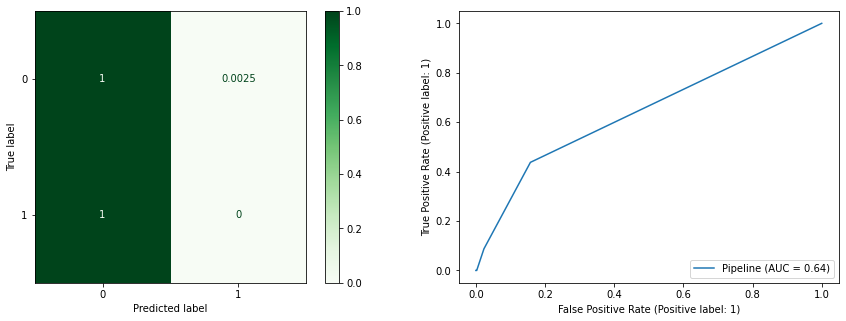

In [256]:
#instantiate
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)
evaluate_classification(knn_pipe, X_test, y_test, "Baseline KNN")

Summary:

With the default knn model we get no true positives, but the accuracy of 0.94 is decently high. Both recall and precision scores are pretty low, being 0.50 and 0.47 respectively on a macro avg standpoint. ROC curve is 0.64 which is pretty low.

What we need: 

We prioritize the recall score as we would want to reduce false negatives. If wanting to accomodate an insurance company as the stakeholders we would want to avoid those who are falsely classified as not having strokes. If we insure those believed to not have strokes, but later on do, that would cost more for the company. Classes are also IMBALANCED, with 1198 negative values and 80 positive values, which will later be dicussed and resolved.

#### Tuning parameters for KNN

In [257]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f77f2da2610>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f77f2da2c90>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeli

In [258]:
param_grid = {'kneighborsclassifier__n_neighbors': range(1,5),
              'kneighborsclassifier__leaf_size': range(1,5)}
knn_pipe_gs = GridSearchCV(knn_pipe, param_grid)
 
knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 4}
Accuracy of best KNN model is: 0.9366197183098591


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Modified KNN
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



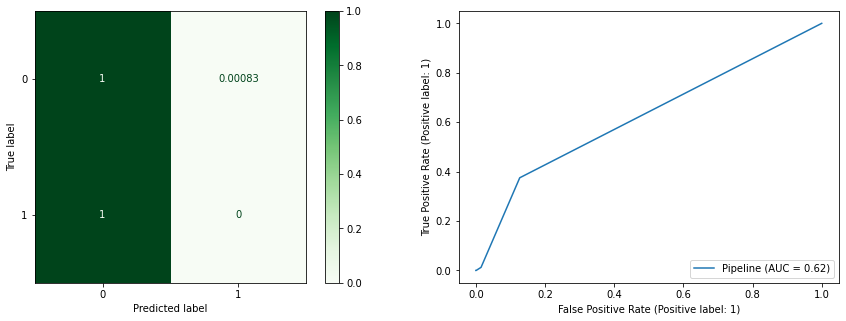

In [259]:
knn1 = KNeighborsClassifier(n_neighbors = 4, leaf_size = 1)
knn1_pipe = make_pipeline(preprocessor, knn1)
knn1_pipe.fit(X_train, y_train)
evaluate_classification(knn1_pipe, X_test, y_test, 'Modified KNN')

Summary: With modified parameters for the knn model the accuracy is the same along with the recall and precision scores being similar as well. The AUC has decreased from 0.64 to 0.62, but we want a value closer to 1. The true and false negatives have stayed the same as well, but the false positives has significantly decreased. We are slowly improving the model. Fixing the imbalanced data may fix the 0 true positives issue.

#### Check for class imbalance

In [260]:
y_train.value_counts(normalize=True)

0    0.955898
1    0.044102
Name: stroke, dtype: float64

very imbalanced: 4% positive class, 96% negative class

##### SMOTE

In [261]:
from imblearn.pipeline import make_pipeline as smote_pipe
from imblearn.over_sampling import SMOTE, RandomOverSampler

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Smote KNN
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1198
           1       0.17      0.28      0.21        80

    accuracy                           0.87      1278
   macro avg       0.56      0.59      0.57      1278
weighted avg       0.90      0.87      0.88      1278



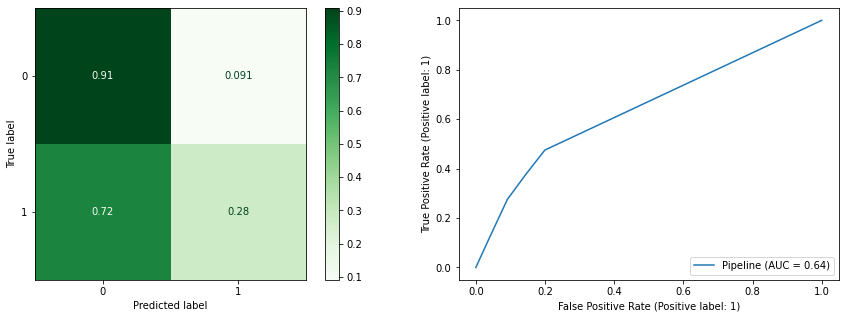

In [262]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
smote_knn = KNeighborsClassifier(n_neighbors = 4, leaf_size = 1)
knn_smote_pipe = smote_pipe(preprocessor, smote, smote_knn)
knn_smote_pipe.fit(X_train, y_train)

evaluate_classification(knn_smote_pipe, X_test, y_test, 'Smote KNN')

Summary: Accuracy has dropped from 0.94 to 0.87, however recall and precision scores have both increased and we have more true positives. Consequently, the false positives have increased, but the false negatives have decreased which is what we prefer to decrease. AUC score is the same as the baseline.
- Cons: Lowest true positive rate
- Pros: highest precision
- Neutral (scores between the other 2 sampling methods): accuracy, recall, AUC score, true negative, false positives, false negatives, true positives

##### Random Undersampling

In [263]:
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.under_sampling import RandomUnderSampler

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Undersampling KNN
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1198
           1       0.14      0.62      0.23        80

    accuracy                           0.73      1278
   macro avg       0.55      0.68      0.53      1278
weighted avg       0.92      0.73      0.80      1278



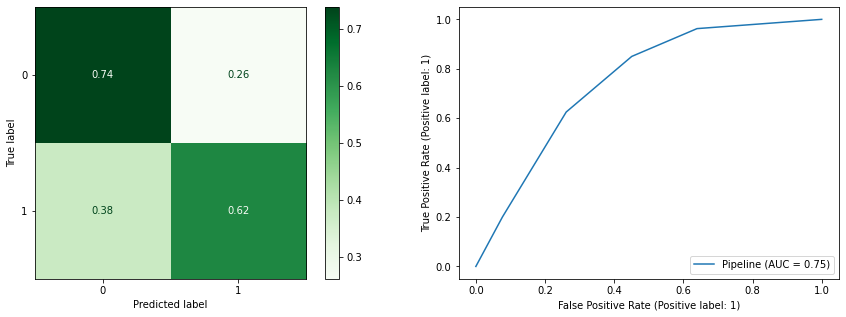

In [264]:
under_sampler = RandomUnderSampler(random_state=42)
under_knn = KNeighborsClassifier(n_neighbors = 4, leaf_size = 1)
knn_under_pipe = make_sampler_pipeline(preprocessor, under_sampler, under_knn)
knn_under_pipe.fit(X_train, y_train)

evaluate_classification(knn_under_pipe, X_test, y_test, 'Undersampling KNN')

Summary: Precision score decreased a little from 0.56 to 0.55, recall has improved from 0.59 to 0.66 which is what we desire, but accuracy has decreased from 0.87 to 0.78. True positives has increased from 22 to 42, but false positives has increased from 112 to 249. It is good, however, that the false negatives, which we want to lessen over the false positives, has decreased from 58 to 38.
- Cons: Lowest accuracy, highest false positives, lowest true negatives, highest false positives
- Pros: highest recall, lowest false negatives, highest true positives, highest AUC score
- Neutral (scores between the other 2 sampling methods): precision

Reduced false negative, but lower accuracy. Much higher false positive.

##### Random Oversampling

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Oversampling KNN
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1198
           1       0.12      0.14      0.13        80

    accuracy                           0.88      1278
   macro avg       0.53      0.53      0.53      1278
weighted avg       0.89      0.88      0.89      1278



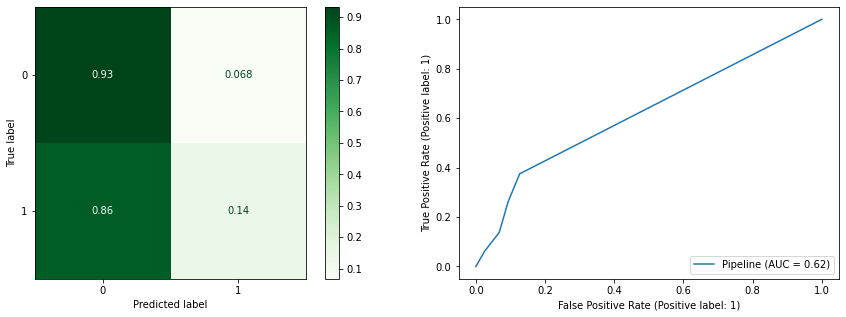

In [265]:
over_sampler = RandomOverSampler(random_state=42)
over_knn = KNeighborsClassifier(n_neighbors = 4, leaf_size = 1)
knn_over_pipe = make_sampler_pipeline(preprocessor, over_sampler, over_knn)
knn_over_pipe.fit(X_train, y_train)

evaluate_classification(knn_over_pipe, X_test, y_test, 'Oversampling KNN')

Summary: Best accuracy score of 0.88 of the 3 balancing methods, however both precision and recall scores are 0.53 which are lower than the two other methods. Oversampling gives higher false negatives than both SMOTE and undersampling.
- Cons: Lowest recall and precision scores, highest false negatives, lowest true positives
- Pros: Highest accuracy, lowest false positives

#### Best Sampling Method:

The best mmethod would have to be the tuned KNN model with the undersampling method as it has the best recall score with the lowest false negatives which is favorable for the stakeholders. The auc score is the highest as well. With the highest true positives this means the company will be saving more money avoiding people who will actually have strokes, potentially costing them more in the future. 

Using the undersampling method we can further tune the KNN model comparing the training and test data to prevent overfitting. 

##### Tune with Undersampling

Using the undersampling method, we can tune the n_neighbors

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Training data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      3663
           1       0.12      0.75      0.21       169

    accuracy                           0.75      3832
   macro avg       0.55      0.75      0.53      3832
weighted avg       0.95      0.75      0.82      3832



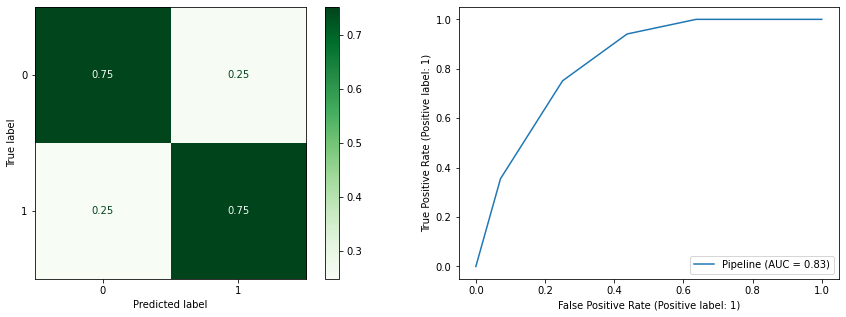

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1198
           1       0.14      0.62      0.23        80

    accuracy                           0.73      1278
   macro avg       0.55      0.68      0.53      1278
weighted avg       0.92      0.73      0.80      1278



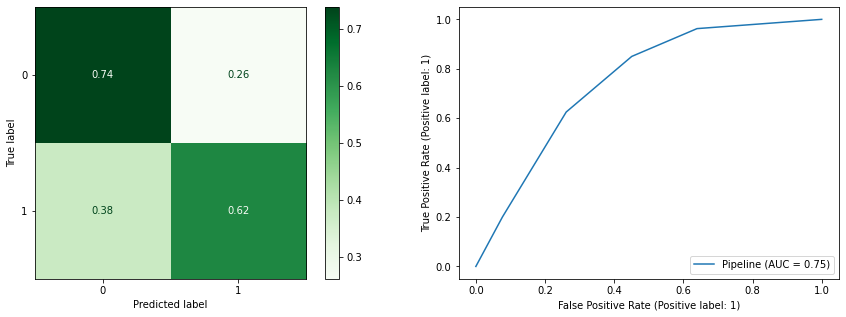

Seems to perform a little better on training data so we can try increasing n_neighbors


In [266]:
under_sampler = RandomUnderSampler(random_state=42)
under_knn = KNeighborsClassifier(n_neighbors = 4, leaf_size = 1)
knn_under_pipe = make_sampler_pipeline(preprocessor, under_sampler, under_knn)
knn_under_pipe.fit(X_train, y_train)
evaluate_classification(knn_under_pipe, X_train , y_train, 'KNN Training data')
evaluate_classification(knn_under_pipe, X_test, y_test, 'KNN Testing Data')
print('Seems to perform a little better on training data so we can try increasing n_neighbors')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Training data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      3663
           1       0.11      0.84      0.20       169

    accuracy                           0.70      3832
   macro avg       0.55      0.77      0.51      3832
weighted avg       0.95      0.70      0.79      3832



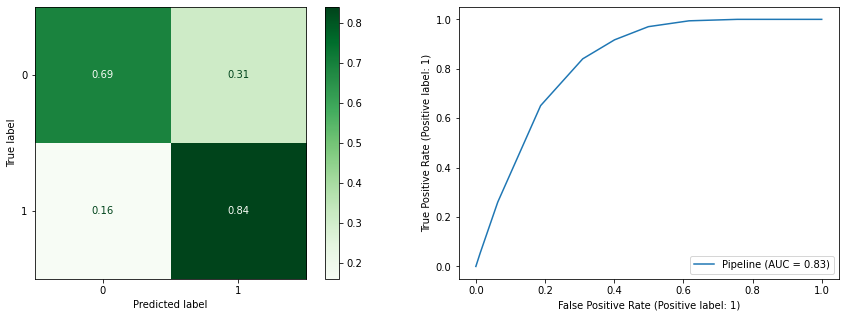

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.14      0.76      0.24        80

    accuracy                           0.70      1278
   macro avg       0.56      0.73      0.53      1278
weighted avg       0.93      0.70      0.78      1278



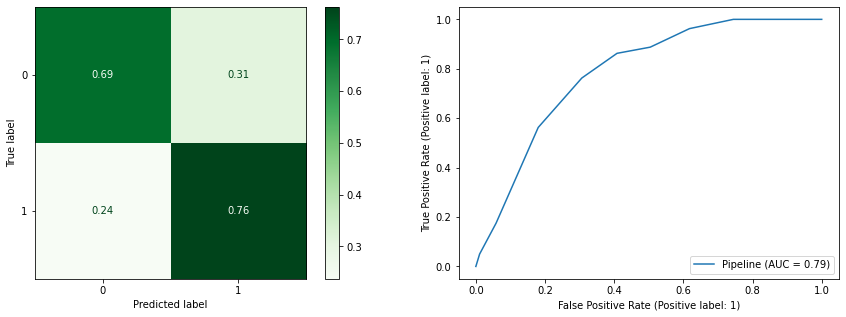

Recall score of testing data increased from 0.68 to 0.73 and false negatives has decreased from 0.38 to 0.24. Can try to increase a little more to try and get better results.


In [267]:
under_sampler = RandomUnderSampler(random_state=42)
under_knn = KNeighborsClassifier(n_neighbors = 8, leaf_size = 1)
knn_under_pipe = make_sampler_pipeline(preprocessor, under_sampler, under_knn)
knn_under_pipe.fit(X_train, y_train)
evaluate_classification(knn_under_pipe, X_train , y_train, 'KNN Training data')
evaluate_classification(knn_under_pipe, X_test, y_test, 'KNN Testing Data')
print('Recall score of testing data increased from 0.68 to 0.73 and false negatives has decreased from 0.38 to 0.24. Can try to increase a little more to try and get better results.')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Training data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.81      3663
           1       0.11      0.86      0.19       169

    accuracy                           0.69      3832
   macro avg       0.55      0.77      0.50      3832
weighted avg       0.95      0.69      0.78      3832



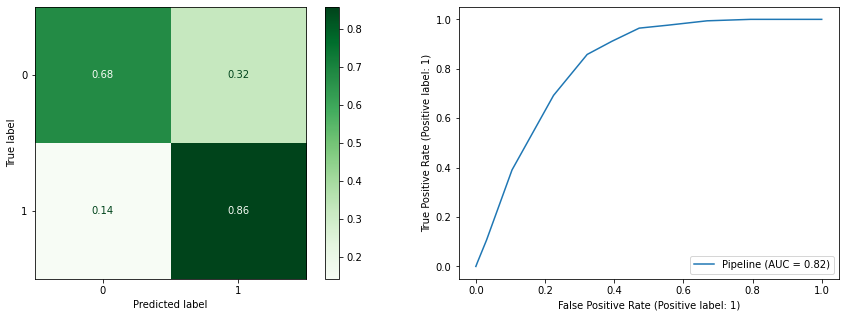

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1198
           1       0.14      0.82      0.25        80

    accuracy                           0.68      1278
   macro avg       0.56      0.75      0.52      1278
weighted avg       0.93      0.68      0.76      1278



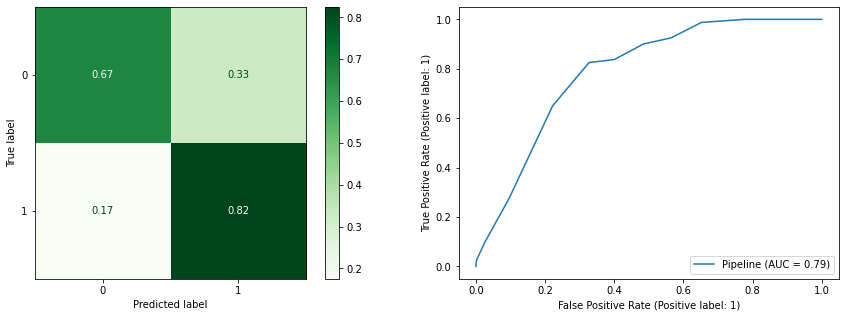

The false negatives has decreased to 0.17 and true positives increased to 0.82 which are very ideal. \The train and test data are showing more similar results to each other.


In [268]:
under_sampler = RandomUnderSampler(random_state=42)
under_knn = KNeighborsClassifier(n_neighbors = 10, leaf_size = 1)
knn_under_pipe = make_sampler_pipeline(preprocessor, under_sampler, under_knn)
knn_under_pipe.fit(X_train, y_train)
evaluate_classification(knn_under_pipe, X_train , y_train, 'KNN Training data')
evaluate_classification(knn_under_pipe, X_test, y_test, 'KNN Testing Data')
print('The false negatives has decreased to 0.17 and true positives increased to 0.82 which are very ideal. \The train and test data are showing more similar results to each other.')

#### Best KNN Model:

The best KNN Model of n_neighbors = 10, leaf_size = 1, and undersampling gave the best results in this scenario with a low false negative rate and high true positive rate. (KNeighborsClassifier(n_neighbors = 10, leaf_size = 1) with undersampler)

### Random Forest

In [269]:
from sklearn.ensemble import RandomForestClassifier

#### Baseline

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Baseline Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.50      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.72      0.51      0.50      1278
weighted avg       0.91      0.94      0.91      1278



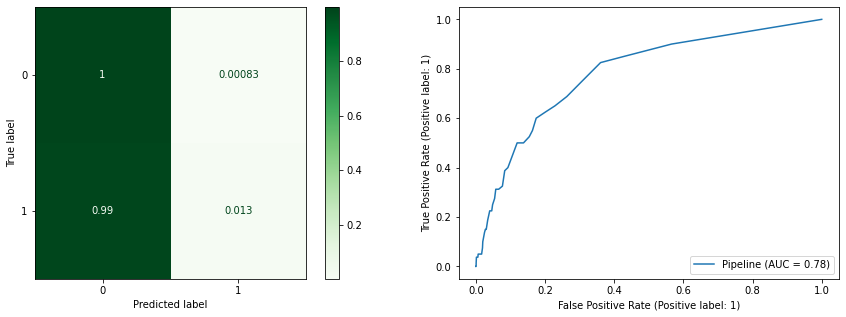

In [270]:
#instantiate
rf = RandomForestClassifier(random_state = 42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)
evaluate_classification(rf_pipe, X_test, y_test, "Baseline Random Forest")

Summary: Accuracy of 0.94 is high as well as the precision score of 0.72. Recall score of 0.51 is pretty low, which is what we prioritize to improve. AUC score of 0.78 is decently high compared to the KNN model. True negatives is 1, but the false negative rate of 0.99 is extremely high. Let's tune the hyperparameters to improve the model.

#### Tuning parameters for Random Forest

In [271]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f77f2da2610>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f77f2da2c90>)])),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline',
                     

In [272]:
param_grid2 = {'randomforestclassifier__max_depth': range(1,20),
              'randomforestclassifier__n_estimators': [50, 100, 150, 200]}
rf_pipe_gs = GridSearchCV(rf_pipe, param_grid2)

rf_pipe_gs.fit(X_train, y_train)
print('Best rf Parameters:')
print(rf_pipe_gs.best_params_)
best_pipe = rf_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

Best rf Parameters:
{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 50}
Accuracy of best KNN model is: 0.9374021909233177


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: test rf
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


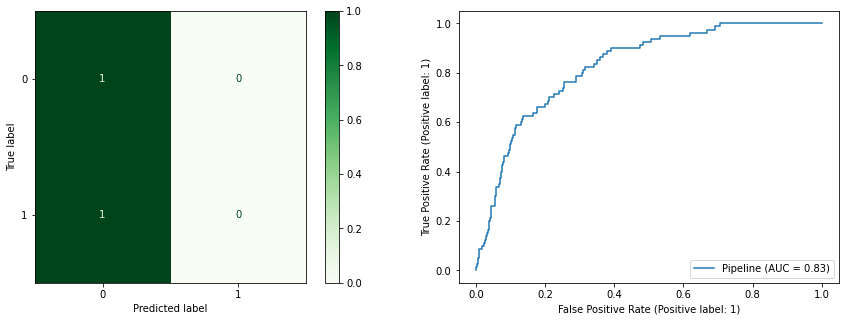

In [273]:
rf1 = RandomForestClassifier(max_depth = 8, n_estimators=50, random_state = 42)
rf1_pipe = make_pipeline(preprocessor, rf1)
rf1_pipe.fit(X_train, y_train)
evaluate_classification(rf1_pipe, X_test, y_test, 'test rf');

Summary: Same accuracy of 0.94 from baseline, but precision and recall scores are lower. AUC score of 0.83 is much higher. The false negative and true positive rates are not looking which could hopefully be fixed with sampling fixes. 

#### Class Imbalance

##### SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Smote Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1198
           1       0.19      0.49      0.27        80

    accuracy                           0.84      1278
   macro avg       0.57      0.67      0.59      1278
weighted avg       0.91      0.84      0.87      1278



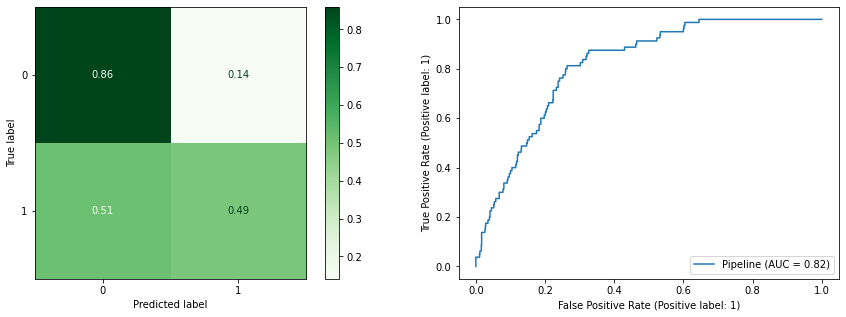

In [274]:
rf_smote = SMOTE(sampling_strategy='auto', random_state=42)
smote_rf = RandomForestClassifier(max_depth = 8, n_estimators=50, random_state = 42)
rf_smote_pipe = smote_pipe(preprocessor, rf_smote, smote_rf)
rf_smote_pipe.fit(X_train, y_train)

evaluate_classification(rf_smote_pipe, X_test, y_test, 'Smote Random Forest')

Summary: Although accuracy has reduced to 0.83, the recall score is better with a rate of 0.67 and precision is 0.57. AUC score of 0.81 is not higher than 0.83 of the tuned model without sample tuning. True positive rate has gone up to 0.49 and false negative has decreased to 0.51. Consequently, false positive has increased to 0.15 and true negative reduced to 0.85. 
- Cons: lowest precision, lowest recall, lowest AUC, highest false negative, lowest true positive
- Pros: highest accuracy, highest true negative, lowest false positive

##### Random Undersampling

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Undersampling Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.15      0.80      0.25        80

    accuracy                           0.70      1278
   macro avg       0.56      0.75      0.53      1278
weighted avg       0.93      0.70      0.78      1278



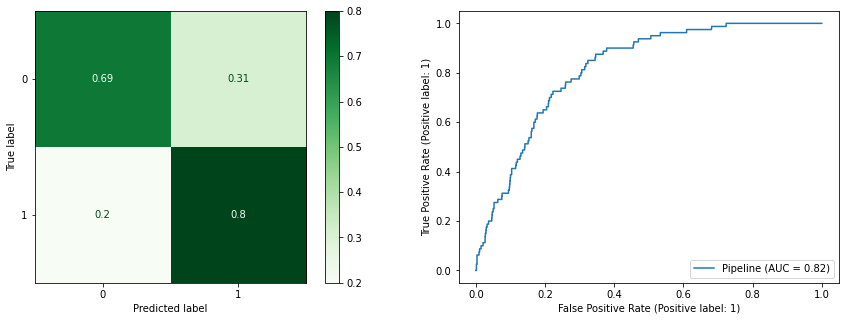

In [275]:
rf_under_sampler = RandomUnderSampler(random_state=42)
under_rf = RandomForestClassifier(max_depth = 8, n_estimators=50, random_state = 42)
rf_under_pipe = make_sampler_pipeline(preprocessor, rf_under_sampler, under_rf)
rf_under_pipe.fit(X_train, y_train)

evaluate_classification(rf_under_pipe, X_test, y_test, 'Undersampling Random Forest')

Summary: Compared to smote, undersampling gives lower accuracy score of 0.72, same precision score, but higher recall score of 0.75. AUC score of 0.82 is a little better than 0.81. False negative has decreased significantly to 0.21 and true positive has increased to 0.79. True negative decreased to 0.71 and false positive increased to 0.29. Since recall score and the reduction of false negatives is prioritized, undersampling is slightly better.
- Cons: lowest accuracy, low precision, 
- Pros: highest recall
- Neutral (scores between the other 2 sampling methods):

##### Random Oversampling

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Oversampling Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      1198
           1       0.19      0.57      0.28        80

    accuracy                           0.82      1278
   macro avg       0.58      0.70      0.59      1278
weighted avg       0.92      0.82      0.86      1278



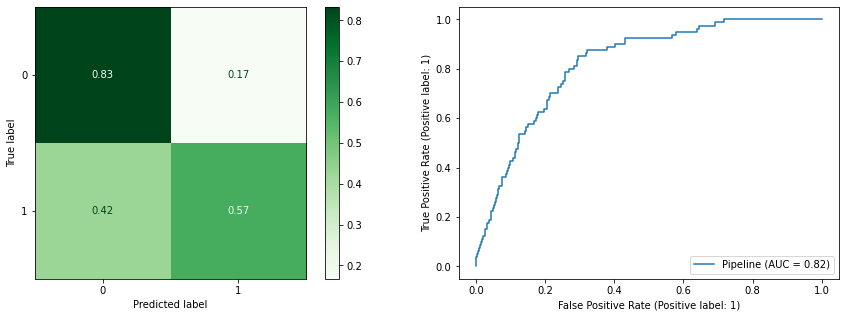

In [276]:
rf_over_sampler = RandomOverSampler(random_state=42)
over_rf = RandomForestClassifier(max_depth = 8, n_estimators=50, random_state = 42)
rf_over_pipe = make_sampler_pipeline(preprocessor, rf_over_sampler, over_rf)
rf_over_pipe.fit(X_train, y_train)

evaluate_classification(rf_over_pipe, X_test, y_test, 'Oversampling Random Forest')

Summary: Oversampling gives a decent accuracy of 0.83, precision score of 0.58, and recall of 0.68, two of which are not much better than undersampling nor smote. AUC score of 0.82 is similar to the previous sample balancing methods. The false negative rate has increased to 0.49 and true positive decreased to 0.51. However, the true negative rate has increased to 0.85 and false positive reduced to 0.15. Though it's good to increase true negatives and reduce false positives, we prioritize a lower false negative and higher true positive. 
- Cons:
- Pros:
- Neutral (scores between the other 2 sampling methods):

#### Best Sampling Method:

Like the KNN model, undersampling gave the best results for random forest. It decreased the false negatives and increased true positives which would save the stakeholders a lot of money. Now we can further tune the model with the undersampling method.

##### Tune with Undersampling

Using the undersampling method, we can tune the max_depth

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Undersampling Train Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      3663
           1       0.13      0.98      0.23       169

    accuracy                           0.71      3832
   macro avg       0.57      0.84      0.53      3832
weighted avg       0.96      0.71      0.80      3832



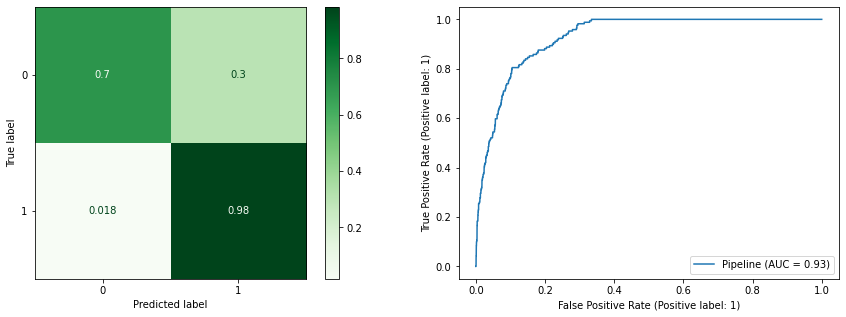

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Undersampling Test Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.15      0.80      0.25        80

    accuracy                           0.70      1278
   macro avg       0.56      0.75      0.53      1278
weighted avg       0.93      0.70      0.78      1278



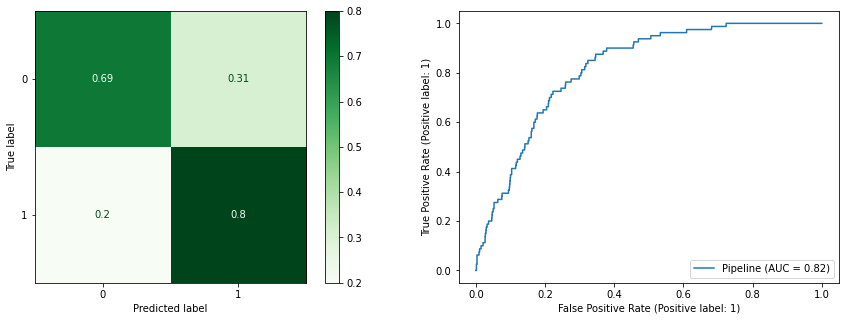

Though accuracy and the f1-score of both sets are not far off, the false negatives of the training data are much lower than that of the test data. 
We can reduce max_depth to decrease variance, avoiding overfitting.


In [277]:
rf_under_sampler = RandomUnderSampler(random_state=42)
under_rf = RandomForestClassifier(max_depth = 8, n_estimators=50, random_state = 42)
rf_under_pipe = make_sampler_pipeline(preprocessor, rf_under_sampler, under_rf)
rf_under_pipe.fit(X_train, y_train)
evaluate_classification(rf_under_pipe, X_train, y_train, 'Undersampling Train Random Forest')
evaluate_classification(rf_under_pipe, X_test, y_test, 'Undersampling Test Random Forest')
print('Though accuracy and the f1-score of both sets are not far off, the false negatives of the training data are much lower than that of the test data. \nWe can reduce max_depth to decrease variance, avoiding overfitting.')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Undersampling Train Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.81      3663
           1       0.12      0.90      0.21       169

    accuracy                           0.69      3832
   macro avg       0.55      0.79      0.51      3832
weighted avg       0.95      0.69      0.78      3832



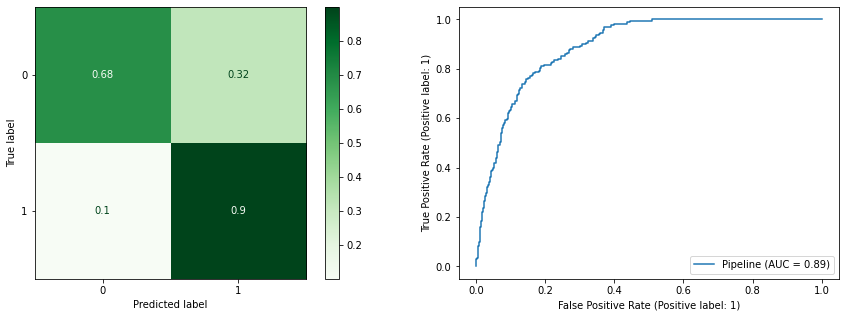

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Undersampling Test Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1198
           1       0.15      0.85      0.26        80

    accuracy                           0.69      1278
   macro avg       0.57      0.76      0.53      1278
weighted avg       0.93      0.69      0.77      1278



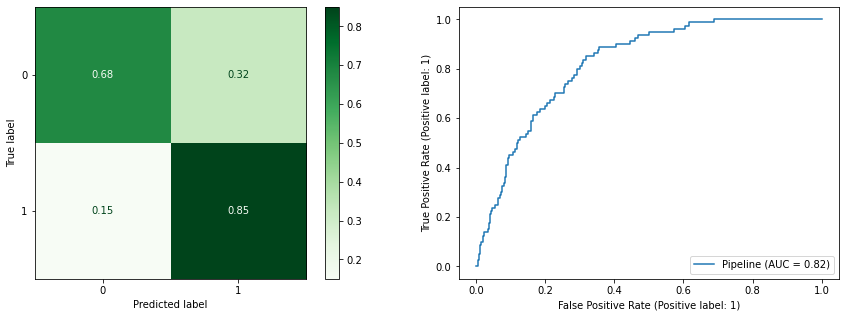

Using max_depth of 5 seems to have lowered the false negatives to 0.15 and increased the true positive rate to 0.85. 
These values are much closer to that of the training data meaning we have alleviated the overfitting problem.


In [278]:
rf_under_sampler = RandomUnderSampler(random_state=42)
under_rf = RandomForestClassifier(max_depth = 5, n_estimators=50, random_state = 42)
rf_under_pipe = make_sampler_pipeline(preprocessor, rf_under_sampler, under_rf)
rf_under_pipe.fit(X_train, y_train)
evaluate_classification(rf_under_pipe, X_train, y_train, 'Undersampling Train Random Forest')
evaluate_classification(rf_under_pipe, X_test, y_test, 'Undersampling Test Random Forest')
print('Using max_depth of 5 seems to have lowered the false negatives to 0.15 and increased the true positive rate to 0.85. \nThese values are much closer to that of the training data meaning we have alleviated the overfitting problem.')

#### Best Random Forest Model

Further tuning the Random Forest model with undersampling decreased the false negatives and increased true positives, potentially saving costs for the stakeholders. The best model involved max_depth = 5, n_estimators = 50, and undersampling to balance the data. This gave the best results with both training and testing data to be close, avoiding overfitting. (RandomForestClassifier(max_depth = 5, n_estimators=50, random_state = 42) with undersampling)

## PCA with Models

In [279]:
from sklearn.decomposition import PCA

### PCA with KNN

In [280]:
# Create a PCA object that will retain 95% of the variance when transforming
pca = PCA(n_components=0.95)

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: PCA KNN Train Model
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.81      3663
           1       0.11      0.88      0.20       169

    accuracy                           0.69      3832
   macro avg       0.55      0.78      0.50      3832
weighted avg       0.95      0.69      0.78      3832



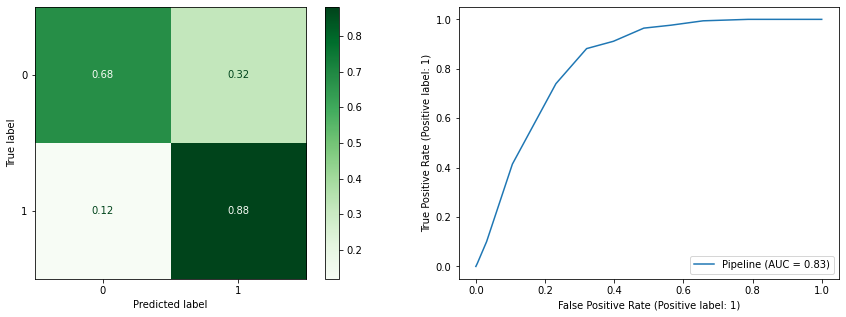

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: PCA KNN Test Model
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      1198
           1       0.14      0.81      0.24        80

    accuracy                           0.67      1278
   macro avg       0.56      0.74      0.51      1278
weighted avg       0.93      0.67      0.76      1278



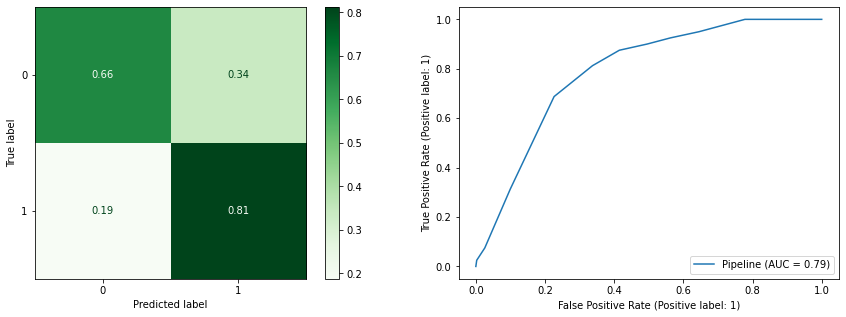

Using pca does not seem to overfit the training data when compared to the test data results. 
When compared to the KNN model without pca, however, it does not show better results.


In [281]:
best_knn_sampler = RandomUnderSampler(random_state = 42)
best_knn = KNeighborsClassifier(n_neighbors = 10, leaf_size = 1)
pca_knn_pipe = make_sampler_pipeline(preprocessor, best_knn_sampler, pca, best_knn)
pca_knn_pipe.fit(X_train, y_train)
evaluate_classification(pca_knn_pipe, X_train, y_train, 'PCA KNN Train Model')
evaluate_classification(pca_knn_pipe, X_test, y_test, 'PCA KNN Test Model')
print('Using pca does not seem to overfit the training data when compared to the test data results. \nWhen compared to the KNN model without pca, however, it does not show better results.')

### PCA with Random Forest

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: PCA RF Train Model
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      3663
           1       0.12      0.95      0.21       169

    accuracy                           0.68      3832
   macro avg       0.56      0.81      0.50      3832
weighted avg       0.96      0.68      0.77      3832



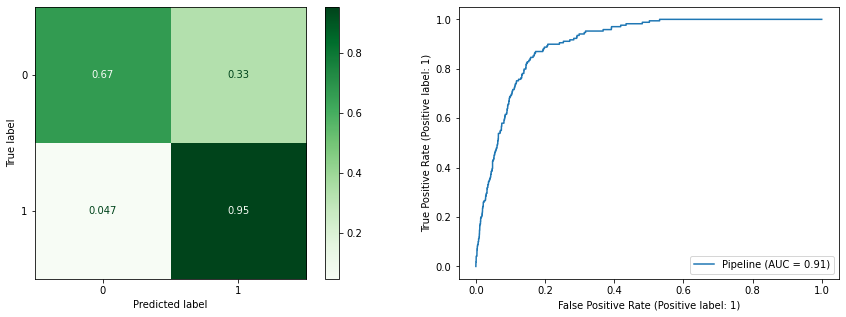

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: PCA RF Test Model
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1198
           1       0.14      0.84      0.24        80

    accuracy                           0.66      1278
   macro avg       0.56      0.74      0.51      1278
weighted avg       0.93      0.66      0.75      1278



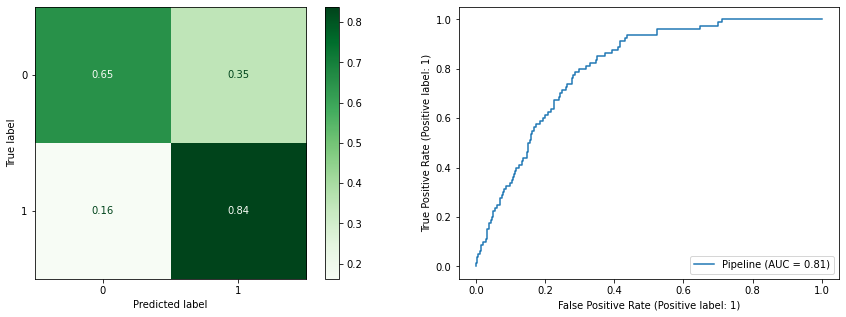

Though the false negative and true positive rates of the pca test data compared to the one without are similar, the accuracy for the model without pca is better. 
Using pca does not improve the model much, if at all.


In [282]:
best_rf_sampler = RandomUnderSampler(random_state = 42)
best_rf = RandomForestClassifier(max_depth = 5, n_estimators=50, random_state = 42)
pca_rf_pipe = make_sampler_pipeline(preprocessor, best_rf_sampler, pca, best_rf)
pca_rf_pipe.fit(X_train, y_train)
evaluate_classification(pca_rf_pipe, X_train, y_train, 'PCA RF Train Model')
evaluate_classification(pca_rf_pipe, X_test, y_test, 'PCA RF Test Model')
print('Though the false negative and true positive rates of the pca test data compared to the one without are similar, the accuracy for the model without pca is better. \nUsing pca does not improve the model much, if at all.')

## Feature Engineering

In [291]:
# Squaring the avg_glucose_level column as it seems to have a correlation with stroke
fe_stroke = ml_stroke.copy()
fe_stroke['glucose2'] = fe_stroke['avg_glucose_level']**2
fe_stroke = fe_stroke.drop(['avg_glucose_level'], axis=1)
fe_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,stroke,glucose2
0,Male,67.0,0,1,Yes,Private,Urban,36.6,formerly smoked,1,52299.1161
1,Female,61.0,0,0,Yes,Self-employed,Rural,NaN,never smoked,1,40888.8841
2,Male,80.0,0,1,Yes,Private,Rural,32.5,never smoked,1,11219.0464
3,Female,49.0,0,0,Yes,Private,Urban,34.4,smokes,1,29319.7129
4,Female,79.0,1,0,Yes,Self-employed,Rural,24.0,never smoked,1,30317.7744


In [284]:
# Validation Split (Use different variables)
X_fe = fe_stroke.drop('stroke', axis=1) 
y_fe = fe_stroke['stroke'] 
X_fe_train, X_fe_test, y_fe_train, y_fe_test = train_test_split(X_fe,y_fe,random_state=42)
X_fe_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,glucose2
4505,Female,60.0,1,0,Yes,Private,Urban,43.7,never smoked,54990.2500
3576,Male,41.0,0,0,Yes,Private,Rural,28.5,formerly smoked,7050.9609
3032,Male,52.0,0,0,Yes,Private,Urban,30.5,formerly smoked,7658.0001
1867,Female,55.0,0,0,Yes,Private,Rural,27.8,Unknown,4028.4409
494,Female,55.0,0,0,Yes,Private,Rural,39.7,formerly smoked,12363.2161


In [285]:
# fit preprocessor onto new train data
fe_preprocessor = make_column_transformer(numeric_tuple, nominal_tuple, remainder='drop')
fe_preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f77f2da2610>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f77f2da2c90>)])

Now we can use the preprocessor on the new data with the models

### KNN Model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1198
           1       0.14      0.82      0.25        80

    accuracy                           0.68      1278
   macro avg       0.56      0.75      0.52      1278
weighted avg       0.93      0.68      0.76      1278



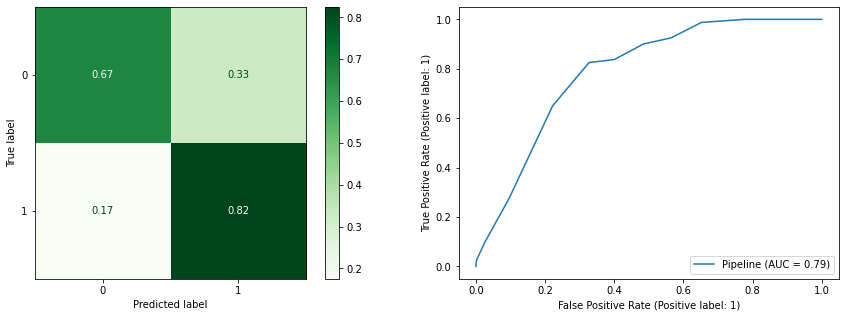

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN FE Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1198
           1       0.14      0.82      0.24        80

    accuracy                           0.68      1278
   macro avg       0.56      0.75      0.52      1278
weighted avg       0.93      0.68      0.76      1278



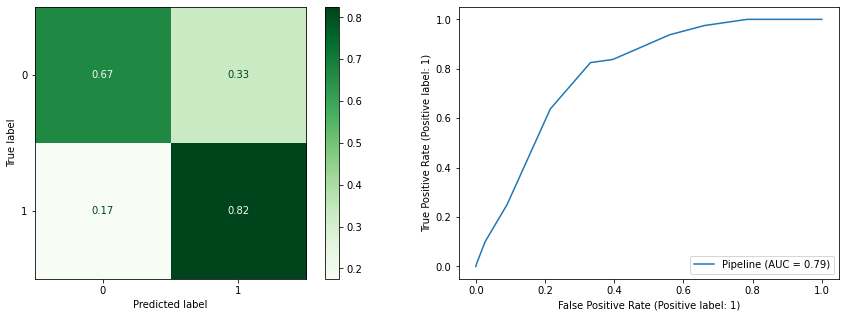

Whether the model involved feature engineering or not, we get the same results with the same false and true rates.


In [286]:
fe_under = RandomUnderSampler(random_state=42)
fe_knn = KNeighborsClassifier(n_neighbors = 10, leaf_size = 1)
fe_knn_pipe = make_sampler_pipeline(fe_preprocessor, fe_under, fe_knn)
fe_knn_pipe.fit(X_fe_train, y_fe_train)
evaluate_classification(knn_under_pipe, X_test, y_test, 'KNN Testing Data')
evaluate_classification(fe_knn_pipe, X_fe_test, y_fe_test, 'KNN FE Testing Data')
print('Whether the model involved feature engineering or not, we get the same results with the same false and true rates.')

### Random Forest Model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Random Forest Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1198
           1       0.15      0.85      0.26        80

    accuracy                           0.69      1278
   macro avg       0.57      0.76      0.53      1278
weighted avg       0.93      0.69      0.77      1278



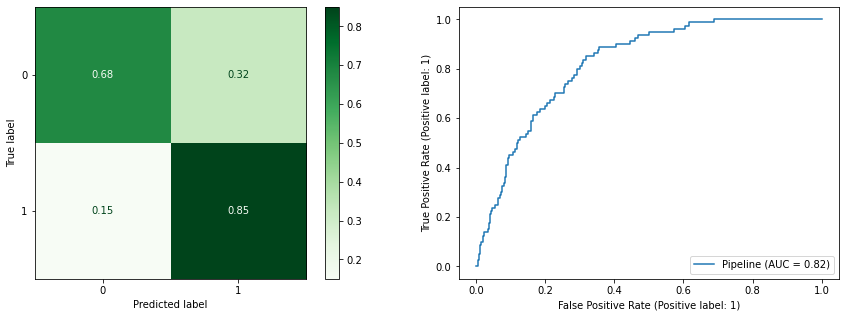

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Random Forest FE Testing Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      1198
           1       0.15      0.84      0.25        80

    accuracy                           0.69      1278
   macro avg       0.57      0.76      0.53      1278
weighted avg       0.93      0.69      0.77      1278



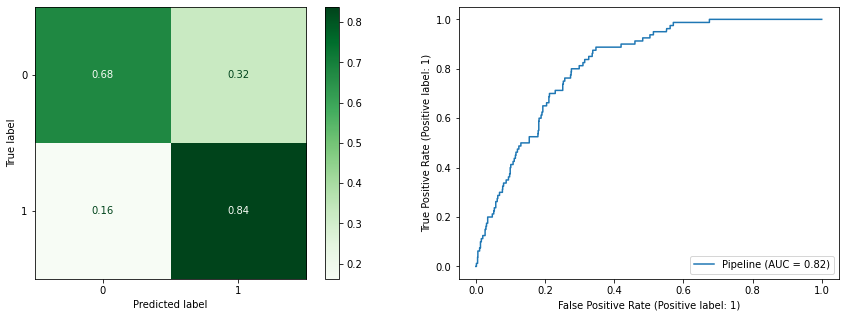

Unlike with the KNN model, the feature engineering changes give different results, although they are not significant enough. Feature engineering gives similar results, 
but the model without the changes is still better with a lower false negative rate and higher true positive rate.


In [293]:
fe_under_rf = RandomUnderSampler(random_state=42)
fe_rf = RandomForestClassifier(max_depth = 5, n_estimators=50, random_state = 42)
fe_rf_pipe = make_sampler_pipeline(fe_preprocessor, fe_under_rf, fe_rf)
fe_rf_pipe.fit(X_fe_train, y_fe_train)
evaluate_classification(rf_under_pipe, X_test, y_test, 'Random Forest Testing Data')
evaluate_classification(fe_rf_pipe, X_fe_test, y_fe_test, 'Random Forest FE Testing Data')
print('Unlike with the KNN model, the feature engineering changes give different results, although they are not significant enough. Feature engineering gives similar results, \nbut the model without the changes is still better with a lower false negative rate and higher true positive rate.')

## Production Model

The best model after tuning and testing, random forest with max_depth = 5, n_estimators=50, random_state = 42, and undersampling gave the best results on the testing data without overfitting on the training data. This model gave the lowest false negative rate of 0.15 with a high true positive rate of 0.85. This is what the stakeholder would prefer to avoid possible false negatives which would save them more costs in the future. 

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Best Model
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1198
           1       0.15      0.85      0.26        80

    accuracy                           0.69      1278
   macro avg       0.57      0.76      0.53      1278
weighted avg       0.93      0.69      0.77      1278



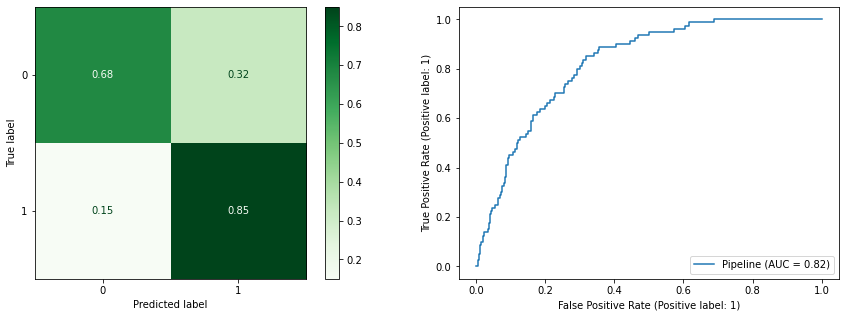

<Figure size 432x288 with 0 Axes>

In [295]:
evaluate_classification(rf_under_pipe, X_test, y_test, 'Best Model')